### For reference refer to this link :[Style Transfer ](https://www.tensorflow.org/tutorials/generative/style_transfer)

In [1]:
import tensorflow as tf
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 

In [2]:
print(os.getcwd())

/content


In [478]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  style_image = image.load_img(path,target_size = (400,512))

uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  content_image = image.load_img(path,target_size = (400,512))

Saving Style 2.jpg to Style 2 (1).jpg


Saving content 5.jpg to content 5 (1).jpg


Text(0.5, 1.0, 'style image')

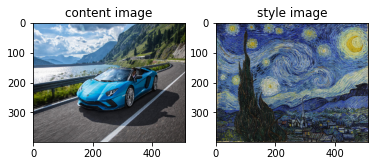

In [479]:
# images : 
plt.subplot(1,2,1)
#plt.axis('off')
plt.imshow(content_image)
plt.title('content image')

plt.subplot(1,2,2)
plt.imshow(style_image)
plt.title('style image')

In [512]:
# converting image to numpy n-dimensional vector
content_img = tf.keras.preprocessing.image.img_to_array(content_image).reshape(1,400,512,3) /255.
style_img = tf.keras.preprocessing.image.img_to_array(style_image).reshape(1,400,512,3) / 255.

In [513]:
from tensorflow.keras.applications.vgg19 import VGG19
model = VGG19(include_top= False,
              weights = 'imagenet',
              input_shape = (400,512,3))
# content_image = load_img('/content/cat.jpg')
# style_image = load_img('/content/sandstone.jpg')

# input : here for content image
x = tf.keras.applications.vgg19.preprocess_input(content_img*255)
x = tf.image.resize(x, (400, 512))

probabilities = model(x)
probabilities.shape

TensorShape([1, 12, 16, 512])

In [514]:
# looking at the predictions for VGG imagenet classfier : 
#predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(probabilities.numpy())[0]
#[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

# since vector isn't normalized the values will be either 1 or 0

In [515]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 400, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 128, 128)     0     

In [516]:
model.trainable = False

# taking block4_conv4 as the intermdeiate layer for decoding content_image:
content_block = ['block5_conv2'] # if layer is near deep end image won't be good 
                                 # and if near start than style won't be good
# taking 4 intermediate layers for decoding style_image :
style_block = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
 # adding block1 to see if color gets similar in context ! 
 

In [517]:
output_layers = content_block + style_block
outputs = [model.get_layer(layer).output for layer in output_layers]

model = tf.keras.Model([model.input],outputs)
model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 400, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 128, 128)     0  

In [518]:
# intializing the final image : 
'''intializing with content_image makes it easier to upgrade at each step '''
#input_image_1 = tf.Variable(tf.random.uniform((1,400,512,3),0,1))#content_img) # it has to be a variable to make it's value changeable
input_image_1 = tf.Variable(content_img)
# also converting our numpy array to tensorflow tensor : 
content_img_ = tf.constant(content_img)
style_img_ = tf.constant(style_img)

# calculating encodings for content and style to use in cost function : 
content_output = model(content_img) # total 5 different tensor outputs
content_output = content_output[0]

style_output = model(style_img) # again 5 outputs
style_output = style_output[1:]


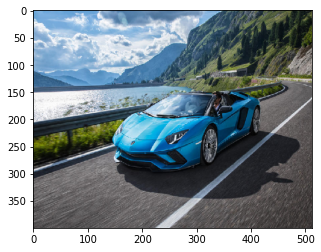

In [519]:
from PIL import Image
# for getting the image back : 
def tensor_to_image(tensor):
  tensor = tensor*(255)
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

d = tensor_to_image(input_image_1.numpy())
#img = Image.fromarray(d, 'RGB')
plt.imshow(d)

In [520]:
# making content cost function :
def content_cost(content_output , img_content):
    m, n_H, n_W, n_C = content_output.get_shape().as_list()
    # Reshape both for same size comaprison : 
    a_C_unrolled = tf.reshape(content_output,shape = [m,-1,n_C])
    a_G_unrolled = tf.reshape(img_content,shape = [m,-1,n_C])
    # computing cost :
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))) #(1/(2*n_H*n_W*n_C))*
    return J_content

In [521]:
# Making gram matrix for style cost : 
def Gram_matrix(M):
  return tf.matmul(M,M,transpose_b = True)

# determining Style Cost : 
def style_cost(style_output, img_style):
  m, n_H, n_W, n_C = style_output.get_shape().as_list() 
  # Again reshaping for suitable cost detemination(n_C, n_H*n_W)
  a_S = tf.transpose(tf.reshape(style_output,shape= [n_H*n_W,n_C]))
  a_G = tf.transpose(tf.reshape(img_style,shape= [n_H*n_W,n_C]))
  # Gram Matrices :
  GS = Gram_matrix(a_S)
  GG = Gram_matrix(a_G)
  # Computing the cost
  J_style_layer =  tf.reduce_sum(tf.square(tf.subtract(GS,GG))) #(1/(4*(n_C**2)*(n_H**2)*(n_W**2))) *
  return J_style_layer

In [522]:
# but the style cost computes for each of the different layers to calculate for
# we need to use some hyperparameters as weights and calculate the total style 
# cost using those weights : 

# estimating our hyperparameter of weights : 
style_weights = [
    (style_block[0], 0.2),     # you can set 
    (style_block[1], 0.2),     # any values for the 
    (style_block[2], 0.2),     # hyperparameter of 
    (style_block[3], 0.2),     # weights 
    (style_block[4], 0.2)]

# computing total style cost : 
def total_style_cost(style_output, img_style, style_weights):
  J_style = 0
  i = 0 
  for layer, value in style_weights :
    J_style += value * style_cost(style_output[i] , img_style[i])
    i += 1
  return J_style

In [523]:
# finally making our total cost : 
def total_cost(J_content, J_style, alpha = 10, beta = 40): 
  # alpha Beta are hyperparameters for total cost
  J = alpha * J_content + beta * J_style
  return J

In [524]:
# defining a function which encloses all the above function into one : 
def loss(input_img, content_output, style_output, style_weights):
  cont_img = input_img[0]
  sty_img = input_img[1:]
  J_content = content_cost(content_output,cont_img)
  J_style = total_style_cost(style_output, sty_img, style_weights)
  J_total = total_cost(J_content, J_style,1e4,1e-2) # we can apply alpha beta values here too ! 

  return J_total

In [525]:
# defining optimizer : 
opt = tf.optimizers.Adam(learning_rate=0.02,beta_1=0.99, epsilon=1e-1)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# now making the function to make gradient descent on the image we want to turn into artistics style
# each function call will make a gradient descent step on the image 
@tf.function()
def training(input_image_1, model, content_output, style_output, style_weights):
  with tf.GradientTape() as tape:
    out = model(input_image_1)
    cost = loss(out,content_output,style_output,style_weights)
  #print(cost)
  # applying gradient descent :
  gradient = tape.gradient(cost, input_image_1)
  opt.apply_gradients([(gradient, input_image_1)])
  input_image_1.assign(clip_0_1(input_image_1))

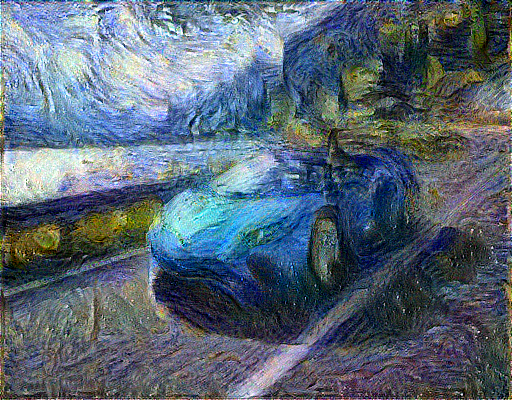

Train step: 500
.........................................................

In [ ]:
# applying 4 times and seeing the output : 
import IPython.display as display
from PIL import Image
import time
start = time.time()
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    training(input_image_1, model, content_output, style_output, style_weights)
    print(".", end='')
    # saving files for each iteration : 
     #file_name = 'stylized-image{}.png'.format(n*1000 + m)
     #file_save = os.path.join(r'/content/save files',file_name)
     #tensor_to_image(input_image_1).save(file_save)

  display.clear_output(wait=True)
  display.display(tensor_to_image(input_image_1))
  print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f} seconds".format(end-start))


data = tensor_to_image(input_image_1.numpy())
#img = Image.fromarray(data, 'RGB')
plt.imshow(data)

In [ ]:
training(input_image_1, model, content_output, style_output, style_weights)
training(input_image_1, model, content_output, style_output, style_weights)

data = tensor_to_image(input_image_1.numpy())
#img = Image.fromarray(data, 'RGB')
plt.subplot(1,3,1)
plt.title('style image')
plt.imshow(style_image)
  
plt.subplot(1,3,2)
plt.title('content image')
plt.imshow(content_image)

plt.subplot(1,3,3)
plt.title('output image')
plt.imshow(data)

fig = plt.gcf()
fig.set_size_inches(25.5, 10.5)

## Running the standard model for Artisitc Style present on Tensorflow : 

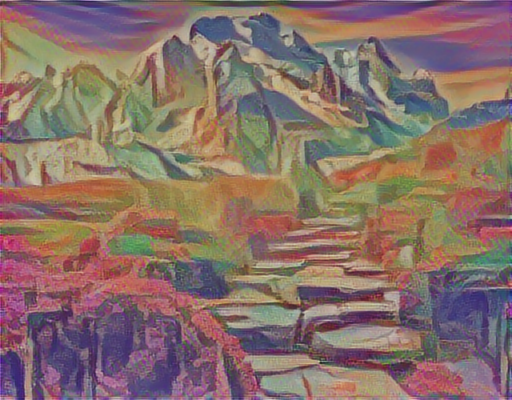

In [429]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_img), tf.constant(style_img))[0]
tensor_to_image(stylized_image)

## Visulizing the Output working : 

In [ ]:
import cv2
import glob
 
img_array = []
for filename in glob.glob('/content/save files/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

NameError: ignored